# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [10]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from collections import deque
from agents import DDPGAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training

In this exercise, I am using Multi agent DDPG with shared replay buffer shared actor-critic networks for both the agents. Each agent is trained for both side of the tennis court.

Before running this section, please ensure that the Section 1 is run where we load the environment.


First we reset the environment, initialize the state space and agents

In [5]:
from agents import DDPGAgent

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents 
num_agents = len(env_info.agents)

# Size of each action
action_size = brain.vector_action_space_size

# Examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

# Define agents
agent = [ DDPGAgent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

In the below section, we train both the agents using DDPG to learn by interacting with the environment.

In [6]:
def multi_ddpg(env, state_size, action_size, brain_name, num_agents, agent, n_episodes=5000, max_t=100000,rate=0.9999,mode=1):
    
    scores_deque = deque(maxlen=100 )
    scores = []
    ddpg_start = time.clock()
    for i_episode in range(1, n_episodes):
        episode_start = time.clock()
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations  # get the current state (for each agent)
        score=np.zeros(num_agents)  # initialize the score (for each agent)

        for i in range(num_agents):
            agent[i].reset() # reset the noise added to the state. Makes the training more robust.
            
        for t in range(max_t):
           # actions = agent.act(states)
            actions = [agent[i].act(states[i],add_noise=True,rate=rate) for i in range(num_agents)] # get action from each agent based on the current state
            env_info = env.step(actions)[brain_name]  # update environment informations with the actions of each agent
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            score = score+rewards  # update the score for each agent
            dones = env_info.local_done  # see if episode finished
            # agent[i].step: add (states,actions,rewards,next_states) to replay buffer of each agent 
            # train the actor critic Neural Network of each agent
            # each agent share the same information
            # There are two possibilities, mode = 0 for not sharing (state,action, etc) and mode = 1 for sharing (state,action, etc). In the second case, the agents are trained to play on both side of the tennis field.
            [agent[i].step(states, actions, rewards, next_states, dones,num_agents) for i in range(num_agents)]
            states = next_states # roll over the state to next time step
            if any(dones):
                break
                
        scores.append(np.max(score)) # save the best agent score for display
        scores_deque.append(np.max(score)) # save the best agent score into the windows for convergence checking
        print('\rEpisode {}\tAverage Score: {}\t Max Score: {}\t Time Taken: {}'.format(i_episode, np.mean(scores_deque), np.max(score), time.clock()-episode_start), end="")
        
        if i_episode%100 ==0 or  i_episode>100 and np.mean(scores_deque)>0.5:
            [torch.save(agent[i].actor_local.state_dict(), 'checkpoint_actor'+str(i)+'.pth') for i in range(num_agents)] # save actor weights for each agents
            [torch.save(agent[i].critic_local.state_dict(), 'checkpoint_critic'+str(i)+'.pth') for i in range(num_agents)] # save critic weights for each agents
            
        if i_episode>100 and np.mean(scores_deque)>0.5: # check if env is solved
            print("\nEnvionment solved after {} episodes, time taken {}".format(i_episode,time.clock()-ddpg_start))
            return scores

    return scores

In [7]:
scores = multi_ddpg(env, state_size, action_size,brain_name,num_agents,agent)

Episode 2760	Average Score: 0.517300007790327	 Max Score: 2.3000000342726707	 Time Taken: 25.4245630000000351253
Envionment solved after 2760 episodes, time taken 2964.590894


In [11]:
def plot_score(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

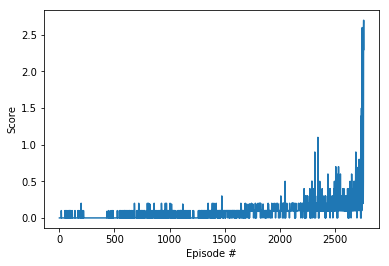

In [12]:
plot_score(scores)